## Lab 1

### Data Quality

The following feautre have signficant NA values that must be handled prior to further analysis.

* *Age*
* *Height*
* *Weight*
* *Medal*

The first area of concern with the overall quality of the data is the number of NAs for the *Height* and *Weight* features (22.19% and 23.19% respectively).  This is exacerbated by the fact that a simple median value imputation will not provide a holistic solution since median height and weight values vary significantly per sport.  For example the mean *Height* for an Olympic Male Basketball player is going to be extremely different from the mean *Height* of a female gymnast.  For this reason, we decided to impute the the *Height*, *Weight*, and *Age* following groupby operations via *Sport* and *Sex*.  *Age* (3.49% NA) also had similar imputation issues as *Height* and *Weight*, so the same method was applied to the *Age* feature. The most populous NA feature is *Medal* (85.33%), however its solution is the simplest.  It can safely be assumed that this is not a mistake since there are three medals awarded per each event per Olympics, so a large percentage of NA values is this column is expcected. NAs in this column were replaced with the string *'No Medal'*. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
df = pd.read_csv('~/olympics/data/athlete_events.csv')
ax = df[['Age', 'Height', 'Weight', 'Medal']].isnull().sum().plot(kind = 'barh')
ax.set_title("Columns with NA Values")
ax.set_xlabel("NA Counts")
ax.set_ylabel("Features")
plt.show()

<Figure size 640x480 with 1 Axes>

In [2]:
agena = (df['Age'].isnull().sum()/len(df['Age'])) * 100
heightna = (df['Height'].isnull().sum()/len(df['Height'])) * 100
weightna = (df['Weight'].isnull().sum()/len(df['Height'])) * 100
medalna = (df['Medal'].isnull().sum()/len(df['Medal'])) * 100
print('Weight NA percentage: %.2f' % (agena) + '%')
print('Height NA percentage: %.2f' % (heightna) + '%')
print('Weight NA percentage: %.2f' % (weightna) + '%')
print('Medal NA percentage: %.2f' % (medalna) + '%')

Weight NA percentage: 3.49%
Height NA percentage: 22.19%
Weight NA percentage: 23.19%
Medal NA percentage: 85.33%


In [3]:
# Fill all Medal NAs with 'No Medal'
df.Medal = df.Medal.fillna('No Medal')
#list of sports with no Height/Weight listed and competed since 1936
oldsports = ['Aeronautics', 'Alpinism', 'Art Competitions','Basque Pelota', 'Cricket', 'Croquet', 'Jeu De Paume','Military Ski Patrol',
             'Motorboating','Polo', 'Racquets', 'Roque']
df1 = df[df['Sport'].isin(oldsports)]
grouped = df1.groupby('Sport')
groupedyear = grouped['Year']
groupedyear = pd.DataFrame(groupedyear.agg('max'))
print(groupedyear)
df['Sport'].value_counts()
#drop the 611 observations containing these sports
df = df.drop(df[df.Sport.isin(oldsports)].index)
# Impute NA values by Sex and Sport
df.Height = df.groupby(['Sex', 'Sport'])['Height'].apply(lambda x: x.fillna(x.mean()))
df.Weight = df.groupby(['Sex', 'Sport'])['Weight'].apply(lambda x: x.fillna(x.mean()))
df.Age = df.groupby(['Sex', 'Sport'])['Age'].apply(lambda x: x.fillna(x.mean()))

                     Year
Sport                    
Aeronautics          1936
Alpinism             1936
Art Competitions     1948
Basque Pelota        1900
Cricket              1900
Croquet              1900
Jeu De Paume         1908
Military Ski Patrol  1924
Motorboating         1908
Polo                 1936
Racquets             1908
Roque                1904


### Further NA discussion:
Upon review of the remaining NAs following the groupby and imputation operations, 12 sports were found to have no data on any athletes for either *Height*, *Weight*, or *Age*.  These sports accounted for 611 observations, a mere 0.22% of the data.  Further investigation showed that these sports had not been played in the Olympics since 1948.  The decision was made to drop these observations from future analysis.  The list of sports can be found in the object: *oldsports*.  As can be seen below, there were no further NA values remaining in the dataset.  A definition for a few of these sports can be found below and provides a clearer understanding as to why these observations have been omitted.
* [Art Competitions](https://en.wikipedia.org/wiki/Art_competitions_at_the_Summer_Olympics) - Medals were awarded for works of art inspired by sport, divided into five categories: architecture, literature, music, painting, and sculpture.  Art competitions were abandoned because artists were considered to be professionals, while Olympic athletes were required to be amateurs.
* [Alpinism](https://www.sports-reference.com/olympics/winter/1924/ALP/) - Medals were awarded to the individual or group that had achieved the most notable feat in mountaineering since the previous Games!  The first medals were awarded to members of the unsuccessful 1922 British expedition to Mt. Everest. This included seven posthumous medals for those who had died!  The final two medals were awarded in 1936.
* [Motorboating](https://en.wikipedia.org/wiki/Water_motorsports_at_the_1908_Summer_Olympics) - Each event included 5 laps around an 8 mile course.  In 1908, only one boat finished and the IOC later deemed the sport non-Olympic! ![alt text](https://upload.wikimedia.org/wikipedia/commons/e/e0/1908_Wolseley-Siddely.JPG)

In [4]:
df.isnull().sum()

ID        0
Name      0
Sex       0
Age       0
Height    0
Weight    0
Team      0
NOC       0
Games     0
Year      0
Season    0
City      0
Sport     0
Event     0
Medal     0
dtype: int64

In [5]:
unique_teams = df.Team.unique()
# Horse names used in Team column for Equestrian Events
print(unique_teams)
dfregions = pd.read_csv('~/olympics/data/noc_regions.csv')
# Merge athletes and regions dataframes to clean country names
df = pd.merge(left = dfregions, right = df, how = 'left', on=['NOC'])

['China' 'Denmark' 'Denmark/Sweden' ..., 'Solos Carex' 'Dow Jones' 'Digby']


### Team Names
A review of the *Team* features revealed that most Team names matched the country for whom the athlete competed for, except in the Equestrian events.  The team name for Equestrian events appeared to be linked to the horses name.  To rectify this, the decision was made to merge data from the *noc_regions.csv* file with the exisiting df dataframe, and rename the *region* feature *Country*.  When this merge was completed the country names for **TUV** and **ROT** were found in the *Notes* Feature, which is later dropped creating NA values in the *Country* column.  The NAs were replaced with **Tuvula** and **Refugee Athlete**.    

In [6]:
df.rename(index = str, columns = {'region' : 'Country'}, inplace = True)
df = df.drop(columns = ['notes'])
#Replace NA values in Country column with Tuvula and Refugee Athlete
df['Country'] = np.where(df['NOC'] == 'TUV', 'Tuvala', df['Country'])
df['Country'] = np.where(df['NOC'] == 'ROT', 'Refugee Athlete', df['Country'])
df = df.drop(df[df['NOC'] == 'UNK'].index)
df.isnull().sum()

NOC        0
Country    0
ID         1
Name       1
Sex        1
Age        1
Height     1
Weight     1
Team       1
Games      1
Year       1
Season     1
City       1
Sport      1
Event      1
Medal      1
dtype: int64

In [7]:
unique_countries = df.Country.unique()
print(len(unique_countries))

208


### Country Names
There are 208 unqiue country names listed in the dataset.  The site [worldometers](http://www.worldometers.info/geography/how-many-countries-are-there-in-the-world/) lists 195 unique country names.  This disparity is due to the large number of country-owned territories that are not officially recognized.  For example, people from the Island of Guam, a US territory, can compete for **Guam** in the Olympics even though Guam is not officially recognized as a country.  A handful of athletes also compete as refugees, which adds to the *Country* totals. It is safe to assume that the remaining country names are valid.

In [8]:
#Extract 'Event' Men's/Women's from the Event Column
df['Event'] = df['Event'].str.replace("(\w+\s+\w+\'s)", '')
df.to_csv('athletes_cleaned_merged.csv')

### Event feature cleaning

The *Event* feature had repeat information that can be found in other columns (ex. **Basketball Men's Basketball**).  For brevity, this was shortened with a regular expression to remove the words preceding an apostrophe s.  Now the *Event* column just reads **Basketball** or **100 metres Butterfly**. 

### Outliers
The three quantitative features *Age*, *Height*, and *Weight* were verified for outliers.  Initial research into past Olympians yielded the following upper and lower bounds:

* Oldest Olympian: **72 Years Old**
* Youngest Olympian: **10 Years 8 Months **
* Tallest Olympian: **226 (cm)**
* Shortest Olympian: **127 (cm)**
* Heaviest Olympian: **214 (kg)**
* Lightest Olympian: **25 (kg)**

So, while these indivdiuals certainly stand out, even from other Olympic athletes, the observations are valid and will remain in the dataset for evaluation.  Judging by the distributions below, *Height* has a fairly normal distribution, while both *Weight* and *Age* are both right skewed with some outliers in the tails.  As expected Male athletes on average are taller and heavier than female athletes, while the *Age* distribution is nearly identical for both genders.

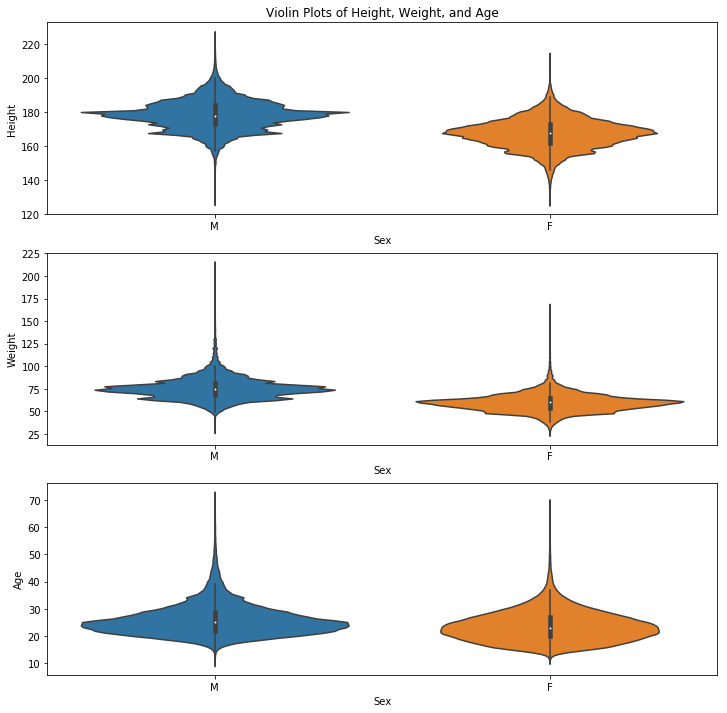

In [9]:
oldolympians = pd.DataFrame(df[df.Age >= 72])
youngolympians = pd.DataFrame(df[df.Age <= 11])
tallestolympians = pd.DataFrame(df[df.Height >= 220])
shortestolympians = pd.DataFrame(df[df.Height <= 130])
heaviestolympians = pd.DataFrame(df[df.Weight >= 200])
lightestolympians = pd.DataFrame(df[df.Weight <= 25])
plt.figure(figsize = (12, 12))
plt.subplot(3, 1, 1)
sns.violinplot(x = 'Sex', y = 'Height', data = df)
plt.title('Violin Plots of Height, Weight, and Age')
plt.subplot(3, 1, 2)
sns.violinplot(x = 'Sex', y = 'Weight', data = df,)
plt.subplot(3, 1, 3)
sns.violinplot(x = 'Sex', y = 'Age', data = df)

## Exceptional Work

For exceptional work, I wanted to leverage the visualizations available in Tableau and add them to our notebook file.  The question I attempted to answer with this visualization is whether or not there is a correlation between the maximum height and weight found in a country's athletes and that country's ability to win Olympic medals.

/Users/Steve/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


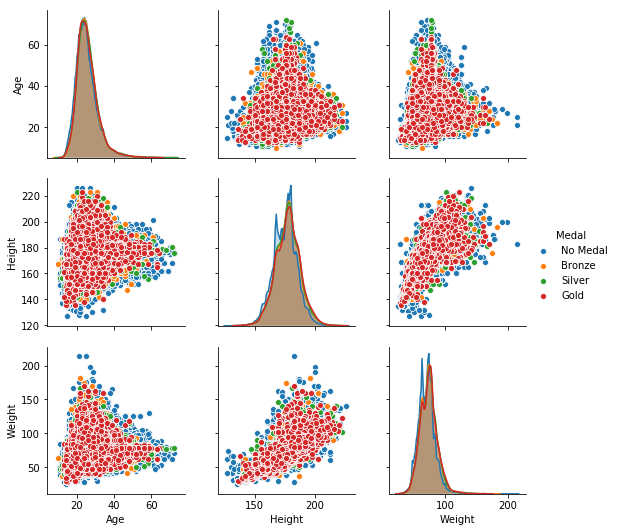

In [10]:
#Create dataframe of Total Medal Counts by Country
grouped = df.groupby(['Country', 'Medal']).size().to_frame(name = 'count').reset_index()
groupedpivot = grouped.pivot_table(index = 'Country', columns = 'Medal')
groupedpivot.fillna(0, inplace = True)
#print(groupedpivot.head())
grouped2 = df.groupby(['Country'])
#Create dataframe of Max Weight by Country
groupedweight = grouped2['Weight']
groupedweight = pd.DataFrame(groupedweight.agg('max'))
#print(groupedweight.head())
#Create dataframe of Max Height by Country
grouped1 = df.groupby(['Country'])
groupedheight = grouped1['Height']
groupedheight = pd.DataFrame(groupedheight.agg('max'))
#print(groupedheight.head())
grouped4 = pd.merge(left = groupedpivot, right = groupedweight, on = ['Country'], left_index = True)
grouped5 = pd.merge(left = grouped4, right = groupedheight, on = ['Country'], left_index = True)
#Send to Excel for import into Tableau
grouped5.to_excel('MedalCounts.xls')

If you have Tableau account and the dashboard cannot be viewed in the online notebook, a copy of the visualization for Top Medal winning countries, along with their max heights and weights can be found [here](https://us-east-1.online.tableau.com/t/smudatascience/views/Olympics/Dashboard1?iframeSizedToWindow=true&:embed=y&:showAppBanner=false&:display_count=no&:showVizHome=no)

In [23]:
%%HTML
<script type='text/javascript' src='https://us-east-1.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1000px; height: 827px;'><object class='tableauViz' width='1000' height='827' style='display:none;'><param name='host_url' value='https%3A%2F%2Fus-east-1.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;smudatascience' /><param name='name' value='Olympics&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='showAppBanner' value='false' /><param name='filter' value='iframeSizedToWindow=true' /></object></div>

If you click a Country in the **MedalsTop20** barchart above, the dashboard will automatically filter the **WeightTop20** and **HeightTop20** barcharts to show the individual country.  The GEO map above will also filter down to the selected country and display the total number of Medals won, along with the total numbers of Gold, Silver, and Bronze Medals. 13 of the 20 (65%) Top 20 Medal winning Countries appear on at least one of the Top 20 Height or Top 20 Weight charts.  7 out of the Top 10 Medal winning countries also appear on the Top 20 Height bar chart.  It is clear that countries with taller and heavier athletes do possess a sizable advantage when it comes to winning Olympic Medals.    